100%|██████████| 9.91M/9.91M [00:01<00:00, 5.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.40MB/s]


Epoch [1/10] | D Loss: 0.3338 | G Loss: 1.4487
Epoch [2/10] | D Loss: 0.4843 | G Loss: 0.8695
Epoch [3/10] | D Loss: 0.5719 | G Loss: 0.7642
Epoch [4/10] | D Loss: 0.7993 | G Loss: 0.6483
Epoch [5/10] | D Loss: 0.5533 | G Loss: 0.9743
Epoch [6/10] | D Loss: 0.3681 | G Loss: 1.2706
Epoch [7/10] | D Loss: 0.7794 | G Loss: 0.7647
Epoch [8/10] | D Loss: 0.6144 | G Loss: 0.8159
Epoch [9/10] | D Loss: 0.6261 | G Loss: 0.9880
Epoch [10/10] | D Loss: 0.4860 | G Loss: 1.0460


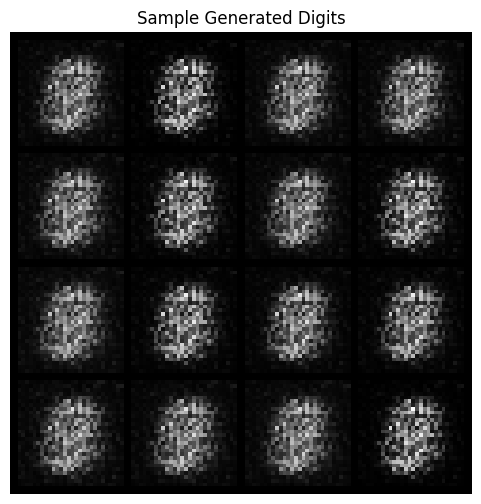

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

# Hyperparameters
latent_dim = 64
batch_size = 128
epochs = 10
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Optimizers and loss function
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=lr)
d_optimizer = optim.Adam(D.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate and visualize final sample images
z = torch.randn(16, latent_dim).to(device)
gen_imgs = G(z).detach().cpu()
grid = utils.make_grid(gen_imgs, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Sample Generated Digits")
plt.show()
